# Alternating Minimization on Real Preference Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes
from helpers.helpers_similarity import *
from helpers.helpers_optimization import *
from scipy.optimize import minimize

In [2]:
# Initialize the parameters for the normal distributions
mu = 0
sigma_u = 1
sigma_v = 1
sigma = 0

# Set the regularization factor
lambda_reg = 0.1

# Create a dictionary to store the parameters
parameters = {}


In [5]:
Y = np.load('data/tensor_Y.npy', allow_pickle=True)
n_users, n_items, _ = Y.shape
print("Shape of the tensor Y: ", Y.shape)

Shape of the tensor Y:  (50, 73, 73)


In [6]:
def generate_P_BT_Luce(X, n_users, alpha=1.0): 
    # Compute the difference matrix
    diff = alpha*np.subtract.outer(X, X) 
    X_diff= np.array([diff[i, :, i, :] for i in range(n_users)])

    # Compute the probability matrix
    P = np.exp(X_diff) / (1 + np.exp(X_diff))
    
    return P, X_diff

In [7]:
def pairwise_comparisons(P):
    # Generate binomial random numbers based on the probabilities in P
    Y = np.random.binomial(n=1, p=P, size=P.shape) 
    Y = np.where(Y == 0, -1, Y)
    
    return Y

In [8]:
def hinge_loss(x):
    return np.maximum(0, 1 - x)**2 

In [9]:
def sum_loss(U, V, Y):
    n, m, _ = Y.shape
    loss = 0
    for j in range(m):
        v = V[:,j] - V.T
        x = np.dot(v, U)
        loss += np.sum(hinge_loss(Y[:,j]*x.T)[:,:j])
    return loss

In [10]:
def loss_U(U, Y, V, lambda_reg, d_dim, n_users):
    U = U.reshape((d_dim, n_users))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(U, 'fro') ** 2 
    
    return loss + reg

In [11]:
def loss_V(V, Y, U, lambda_reg, d_dim, n_movies):
    V = V.reshape((d_dim, n_movies))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(V, 'fro') ** 2
    
    return loss + reg

In [12]:
def initialize_parameters(Y, sigma_u, sigma_v, mu, d_dims, n_users, n_movies, lambda_reg):  

    U_init = np.random.normal(mu, sigma_u, (d_dims, n_users))
    V_init = np.random.normal(mu, sigma_v, (d_dims, n_movies))   
   
    parameters['Y'] = Y
    parameters['U_result'] = U_init
    parameters['V_result'] = V_init
    parameters['lambda_reg'] = lambda_reg

In [13]:
def update_parameters(d_dim, n_users, n_movies):
    U_prev = parameters['U_result']
    V_prev = parameters['V_result']
    Y = parameters['Y']

    U_prev = U_prev.reshape((d_dim, n_users))
    V_prev = V_prev.reshape((d_dim, n_movies))

    U_result = minimize(loss_U, U_prev, args=(Y, V_prev, lambda_reg, d_dim, n_users), method='L-BFGS-B')
    V_result = minimize(loss_V, V_prev, args=(Y, U_prev, lambda_reg, d_dim, n_movies), method='L-BFGS-B')
    
    U_result = U_result.x.reshape((d_dim, n_users))
    V_result = V_result.x.reshape((d_dim, n_movies))
    
    parameters['U_result'] = U_result
    parameters['V_result'] = V_result

In [14]:
def loss(d_dim, n_users, n_movies):
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    Y = parameters['Y']
    lambda_reg = parameters['lambda_reg']

    loss_u = loss_U(U_result, Y, V_result, lambda_reg, d_dim, n_users) /(d_dim*n_users) 
    loss_v = loss_V(V_result, Y, U_result, lambda_reg, d_dim, n_movies) /(d_dim*n_movies)
    
    return loss_u, loss_v


In [15]:
def orth_procrustes(X, Y, len_X):
    
    R, _ = orthogonal_procrustes(X, Y)
    rss = np.linalg.norm(X @ R - Y, 'fro')/np.sqrt(len_X)
    
    return rss

In [16]:
def compare_results(n_users):
    # Extract Y, U_result, V_result from parameters
    Y = parameters['Y']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    
    # Compute product of U_result and V_result to get predicted preferences
    X_result = np.matmul(U_result.T, V_result)

    total_score = 0

    # Iterate over each user
    for u in range(n_users):
        # Iterate over all pairs of items for the current user
        for i in range(Y.shape[1]):
            for j in range(Y.shape[2]):
                # If user u prefers item i over item j
                if Y[u, i, j] > 0:
                    # Add 1 to total_score if the predicted preference matches the actual preference
                    if X_result[u, i] > X_result[u, j]:
                        total_score += 1
                        
    average_score = total_score / n_users

    return average_score


In [17]:
def alt_minimization_U_V(Y, d_dims, n_users, n_movies):
    
    initialize_parameters(Y, sigma_u, sigma_v, mu, d_dims, n_users, n_movies, lambda_reg) 
    loss_u_vals = []
    loss_v_vals = []

    for i in range(10): 
        if len(loss_u_vals) > 2:
            if np.abs(loss_u_vals[-1] - loss_u_vals[-2]) < 0.1:
                break
        update_parameters(d_dims, n_users, n_movies)

        loss_u, loss_v = loss(d_dims, n_users, n_movies)
        loss_u_vals.append(loss_u)
        loss_v_vals.append(loss_v) 
        if i % 5 == 0:
            print(f'loss_u: {loss_u}, loss_v: {loss_v}')      
                
    average_score = compare_results(n_users)
    
    return average_score, loss_u_vals, loss_v_vals


In [27]:
def plot_results(data):

    df = pd.DataFrame(data, columns = ['D', 'avg_score']) 

    # plot D as a function of the Average Prediction Score
    plt.plot(df['D'], df['avg_score'], marker='o')
    plt.xlabel('D')
    plt.ylabel('Average Prediction Score')
    plt.title('Variation of the Average Prediction Score for varying D')

    plt.show()

In [19]:
data = []
d_dims = [5, 10, 20, 30, 50]

for i in range(len(d_dims)):

    avg_score, loss_u_vals, loss_v_vals = alt_minimization_U_V(Y, d_dims[i], n_users, n_items)
    row= [d_dims[i], avg_score]
    data.append(row)


/var/folders/y6/l6vpn95x35g0swp7xwnqndtc0000gn/T/ipykernel_40453/1314612138.py:9: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  U_result = minimize(loss_U, U_prev, args=(Y, V_prev, lambda_reg, d_dim, n_users), method='L-BFGS-B')
/var/folders/y6/l6vpn95x35g0swp7xwnqndtc0000gn/T/ipykernel_40453/1314612138.py:10: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  V_result = minimize(loss_V, V_prev, args=(Y, U_prev, lambda_reg, d_dim, n_movies), method='L-BFGS-B')


loss_u: 526.5015573701946, loss_v: 360.6225533257063
loss_u: 262.9759371925044, loss_v: 180.13596957778623
loss_u: 131.46894224572293, loss_v: 90.0758246670942
loss_u: 87.55420517996973, loss_v: 60.03496386046339
loss_u: 52.592970579043765, loss_v: 36.06355121909303


In [21]:
data

[[5, 1.18], [10, 1.3], [20, 1.66], [30, 1.84], [50, 1.92]]

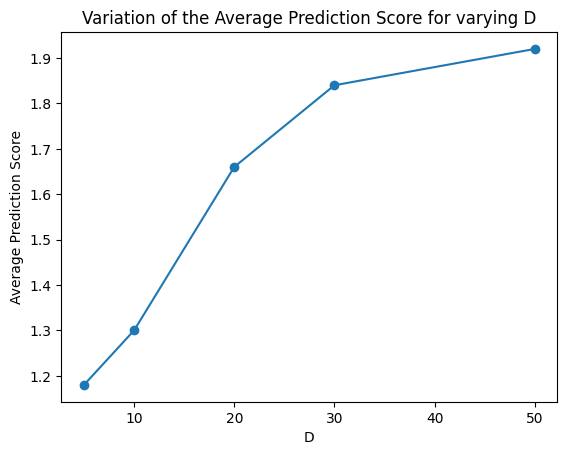

In [28]:
plot_results(data)

In [49]:
plt.savefig('results_realpref.pdf')

<Figure size 640x480 with 0 Axes>